<a href="https://colab.research.google.com/github/031wnstjd/Deep-Learning/blob/master/DL_05_Backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL_05 - Backpropagation


In [ ]:
name = input("Name :")
ID = input("student ID :")

Name :추준성
student ID :2016145028


## 실습
___


## Matrix 미분 정리
$H = XW+b$ </br> $(1,h) = (1,d)x(d,h)+(1,h)$</br>
$L = f(H)$</br>
$\frac{\partial L}{\partial W} = \frac{\partial H}{\partial W} \times \frac{\partial L}{\partial H} = \frac{\partial (XW+b)}{\partial W} \times\frac{\partial L}{\partial H} = X *\frac{\partial L}{\partial H}$</br>
$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial H}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial (XW+b)}{\partial X} = \frac{\partial L}{\partial H}*W$</br>
$\frac{\partial L}{\partial b}=1*\frac{\partial L}{\partial H}$</br>

## 2 Layer Chain Rule

### Forward
$H = XW_{1} + b$</br>
$A = ReLU(H)$</br>
$O = AW_{2} + b_{2}$</br>
$P = Softmax(O)$</br>
$L = Crossentropy(P)$</br>

### Backward
$\frac{\partial L}{\partial O} = P-T$</br>
> _$P$:predicted value $T$:target(label)_ </br>

$\frac{\partial L}{\partial W_{2}} = \frac{\partial O}{\partial W_{2}}\frac{\partial L}{\partial O} = A^{T}(P-T) $</br>
$\frac{\partial L}{\partial b_{2}} = 1*\frac{\partial L}{\partial O} = P-T$</br>
$\frac{\partial L}{\partial A} = \frac{\partial L}{\partial O}\frac{\partial O}{\partial A} = (P-T){W_{2}}^{T} $</br>
$\frac{\partial L}{\partial H} = \frac{\partial A}{\partial H}\frac{\partial L}{\partial A}$ #RELU미분과 (Loss를 A에 대하여 미분) 곱하기!!!!</br>
$\frac{\partial L}{\partial W_{1}} = \frac{\partial H}{\partial W_{1}}\frac{\partial L}{\partial H} = X^{T}\frac{\partial L}{\partial H}$</br>
$\frac{\partial L}{\partial b_{1}} = \frac{\partial L}{\partial H}$ 

2 Layer Network를 완성하시오


In [ ]:
import torch

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    self.params = {}
    torch.manual_seed(0)

    # 각 parameter W1, b1, W2, b2에 각 Layer에 상응하는 행렬에 랜덤 값 지정
    self.params["W1"] = torch.rand(input_size,hidden_size).cuda().type(torch.cuda.DoubleTensor) 
    self.params["b1"] = torch.rand(1,hidden_size).cuda().type(torch.cuda.DoubleTensor)
    self.params["W2"] = torch.rand(hidden_size, output_size).cuda().type(torch.cuda.DoubleTensor)
    self.params["b2"] = torch.rand(1,output_size).cuda().type(torch.cuda.DoubleTensor)
  
  def relu(self, x):
    return torch.max(torch.zeros_like(x), x)

  def softmax(self, x):
    return torch.exp(x) / torch.sum(torch.exp(x))

  def forward(self, X, y = None):

    # forward 함수에서 사용하는 변수인 W1, b1, W2, b2에 forward 함수를 거치기 전(즉, 업데이트 전) parameter들을 할당함 
    W1, b1 = self.params["W1"], self.params["b1"]
    W2, b2 = self.params["W2"], self.params["b2"]
    
    h = torch.matmul(X,W1) + b1
    a = self.relu(h)
    o = torch.matmul(a,W2) + b2
    p = self.softmax(o)

    if y is None: # y값(=target)이 입력이 없을 땐 p와 a를 반환
      return p, a
    
    # p.shape[1] = p-layer에 있는 원소들의 개수 (1 x p.shape[1] 행렬이므로)
    # => 데이터 하나에 대해서 다루고 있기 때문에 이런식으로 for문 설정.(만약 n개의 데이터에 대해 다루면 input X는 n x X.shape[1], p는 n x p.shape[1] 행렬이 될 것)
    # y는 원핫 인코딩 안 되어 있는 스칼라 값임. 따라서 기존의 Crossentropy 식을 Loss에 그대로 적용하면 안됨.

    for i in range(p.shape[1]): 
      if i == y: # y값(=target)이 있을 땐 Loss를 계산하여 반환
        Loss = -torch.log(p[0][i] + 1e-7)
    return Loss


  def backward(self, X, y, learning_rate=1e-5):
      """
      X: input 데이터 (D,) Dx1 행렬
      y: 레이블 (N,) Nx1 행렬
      grads에는 Loss에 대한 W1, b1, W2, b2 미분 값이 기록됩니다.
      원래 backw 미분 결과를 return 하지만
      여기서는 Gradient Descent방식으로 가중치 갱신까지 합니다.
      """
      W1, b1 = self.params["W1"], self.params["b1"]
      W2, b2 = self.params["W2"], self.params["b2"]

      grads = {}

      p, a = self.forward(X) # y값이 입력으로 없으므로 forward(X)는 p와 a값을 반환

      # 여기에 파라미터에 대한 미분을 저장하세요.(dp는 Loss를 o로 편미분한 값)

      dp = p # dp값을 p로 초기화 (정의상 dp = p-y인데, i==y이면 y=1 이므로 dp=p-1이어야 하고, i!=y이면 y=0 이므로 dp=p여야 함)

      for i in range(p.shape[1]):
        if i==y: #일치 or 불일치
          dp[0][i] -= 1 # p-y
      
      h = torch.matmul(X,W1)+b1
      da = torch.heaviside(h, values=torch.tensor(0,dtype=torch.float64)) #step function = ReLU미분 ->  torch.heaviside(input, values, *, out=None) → Tensor
      
      grads["W2"] = torch.matmul(a.T, dp)
      grads["b2"] = dp
      grads["W1"] = torch.matmul(X.T, da*torch.matmul(dp, W2.T))
      grads["b1"] = da*torch.matmul(dp, W2.T)


      self.params["W2"] -= learning_rate * grads["W2"]
      self.params["b2"] -= learning_rate * grads["b2"]
      self.params["W1"] -= learning_rate * grads["W1"]
      self.params["b1"] -= learning_rate * grads["b1"]

  def accuracy(self, X, y):

      p, _ = self.forward(X) # p값만 받아옴. label 값과 p값을 비교하여 accuracy 계산을 하기 위함

      pred = torch.argmax(p,dim=1) # p값들 중에 가장 큰 값의 index를 반환
      acc = torch.sum(pred==y).float()/X.shape[0]*100 # torch.sum(pred==y).float() 은, pred가 y와 같을 때(=정답)의 개수를 더해주는 걸 의미. => 여기선 pred==y이면 값은 1이고 pred!=y이면 값은 0.(X.shpae[0] = 데이터의 개수)

      return acc

  


#### Data

In [ ]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
(x_train, y_train), (x_test, y_test) = mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : (60000, 28, 28)
shape of y_train : (60000,)
shape of x_test : (10000, 28, 28)
shape of y_test : (10000,)


In [ ]:
def preprocessing_data(x_train, x_test, y_train, y_test):
    x_train = x_train[:5000]
    y_train = y_train[:5000]
    x_test = x_test[:1000]
    y_test = y_test[:1000]

    #change dtype
    x_train = torch.from_numpy(x_train).cuda()
    x_test = torch.from_numpy(x_test).cuda()

    x_train = torch.tensor(x_train,dtype=torch.float64, device="cuda:0")
    y_train = torch.tensor(y_train,device="cuda:0")

    x_test = torch.tensor(x_test,dtype=torch.float64,device="cuda:0")
    y_test = torch.tensor(y_test,device="cuda:0")
    
    #reshaping
    x_train = x_train.reshape([x_train.shape[0],-1]) # flatten => (1, 784)로 reshaping
    x_test = x_test.reshape(x_test.shape[0],-1)


    #normalization
    mean_value = torch.mean(x_train, dim=0)
    x_train -= mean_value
    x_train = x_train/255
    x_test -= mean_value
    x_test = x_test/255

    
    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = preprocessing_data(x_train, x_test, y_train, y_test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : torch.Size([5000, 784])
shape of y_train : torch.Size([5000])
shape of x_test : torch.Size([1000, 784])
shape of y_test : torch.Size([1000])


In [ ]:
y_train[0]

tensor(5, device='cuda:0', dtype=torch.uint8)

In [ ]:
N = x_train.shape[0] # 데이터의 개수
input_size = x_train.shape[1] # input의 개수
hidden_size = 5 # hidden layer의 weight의 개수 
output_size = 10 # output target 종류의 개수 0~9까지의 숫자 10개에 대하여 어떤 값을 산출 => 이 값들이 softmax를 거쳐서 확률 값으로 변환됨
epoch_size = 100 # 반복 횟수 
learning_rate = 1e-3

import numpy as np

nn = TwoLayerNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
history = {'val_acc': [],'val_loss': []}
#코드를 보며 epoch, batch에 대해서 이해해봅시다.
for i in range(epoch_size):
    for j in range(N): # batch 없이 데이터 개수 N개 만큼 sample 하나를 갖고 training
        x_now = x_train[j].unsqueeze(0) # unsqueeze(0) : index 0번째에 차원을 만들고 1 값을 할당. => (D)를 (1,D)로 shape 변환한 것임 => Sample 하나 갖고 forward를 돌릴 것이므로 (1,D)
        t_now = y_train[j]
        
        nn.backward(x_now, t_now, learning_rate) # 가중치 갱신

    #accuracy와 loss를 기록해둡시다.
    val_acc = 0
    val_loss = 0
    for k in range(x_test.shape[0]): # x_test.shape[0] = 데이터의 개수
        val_acc += nn.accuracy(x_test[k].unsqueeze(0), y_test[k]) # nn클래스 내의 accuracy 함수는 accuracy 값을 반환하므로 각 데이터마다의 accurcy 값 누적 (데이터 개수만큼의 training을 했을 때 accuracy)
        val_loss += nn.forward(x_test[k].unsqueeze(0), y_test[k]) # nn클래스 내의 forward 함수는 y값이 있을 때 loss값을 반환하므로 각 데이터마다의 loss 값 누적 (데이터 개수만큼의 training을 했을 때 loss)
    history["val_acc"].append(val_acc/x_test.shape[0]) # plot 그리기 위해서 매번의 epoch당 리스트에 저장
    history["val_loss"].append(val_loss/x_test.shape[0]) # plot 그리기 위해서 매번의 epoch당 리스트에 저장
    
    if i % 10 == 0: # 10번마다 출력
        # print(i, "train accuracy :", nn.accuracy(x_train, y_train))
        # print(i, "train loss     :", nn.forward(x_train, y_train))
        print(i, "test accuracy :", val_acc/x_test.shape[0])
        print(i, "test loss     :", val_loss/x_test.shape[0])
        print("============================================")

0 test accuracy : tensor(25.4000, device='cuda:0')
0 test loss     : tensor(2.1951, device='cuda:0', dtype=torch.float64)
10 test accuracy : tensor(49.5000, device='cuda:0')
10 test loss     : tensor(1.5178, device='cuda:0', dtype=torch.float64)
20 test accuracy : tensor(54.4000, device='cuda:0')
20 test loss     : tensor(1.3802, device='cuda:0', dtype=torch.float64)
30 test accuracy : tensor(58.1000, device='cuda:0')
30 test loss     : tensor(1.3098, device='cuda:0', dtype=torch.float64)
40 test accuracy : tensor(61.2000, device='cuda:0')
40 test loss     : tensor(1.2446, device='cuda:0', dtype=torch.float64)
50 test accuracy : tensor(63.3000, device='cuda:0')
50 test loss     : tensor(1.1911, device='cuda:0', dtype=torch.float64)
60 test accuracy : tensor(65.8000, device='cuda:0')
60 test loss     : tensor(1.1228, device='cuda:0', dtype=torch.float64)
70 test accuracy : tensor(68., device='cuda:0')
70 test loss     : tensor(1.0657, device='cuda:0', dtype=torch.float64)
80 test accura

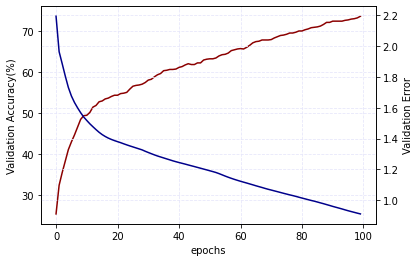

나의 최고 test accuracy :  tensor(73.7000, device='cuda:0')


In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size), history['val_acc'], label='정확도(%)', color='darkred')
#plt.text(3, 14.7, "<----------------정확도(%)", verticalalignment='top', horizontalalignment='right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()
ax_loss.plot(range(epoch_size), history['val_loss'], label='오차', color='darkblue')
#plt.text(3, 2.2, "<----------------오차", verticalalignment='top', horizontalalignment='left')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

print("나의 최고 test accuracy : ",max(history['val_acc']))